In [1]:
import ibis
import pandas as pd
# local
from settings import conf
from gen_data import salary_date, salary_date_schema

In [2]:
con = ibis.postgres.connect(**conf['postgres'])

In [3]:
df_salary1 = salary_date()
df_salary1.rename(columns={'timestamp_of_birth': 'outtime'}, inplace=True)
df_salary1.drop(columns='date_of_birth', inplace=True)
df_salary1 = df_salary1.assign(intime=df_salary1.outtime + pd.to_timedelta(1000, 'd'))
df_salary1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   last_name  4018 non-null   object        
 1   salary     4018 non-null   float64       
 2   outtime    4018 non-null   datetime64[ns]
 3   intime     4018 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 125.7+ KB


In [4]:
sch = salary_date_schema()
sch = sch.delete(['date_of_birth', 'timestamp_of_birth'])
sch = sch.append(
    ibis.schema((
        ('intime', 'timestamp'),
        ('outtime', 'timestamp'),
    ))
)
sch

ibis.Schema {  
  last_name  string
  salary     float64
  intime     timestamp
  outtime    timestamp
}

In [5]:
table_name = 'salary_time_interval'

con.drop_table(table_name, force=True)
con.create_table(table_name, schema=sch)
con.load_data(table_name, df_salary1, if_exists='append')
t = con.table(table_name)

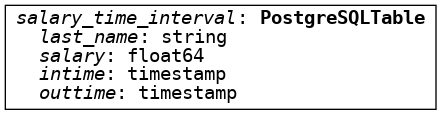

In [6]:
t

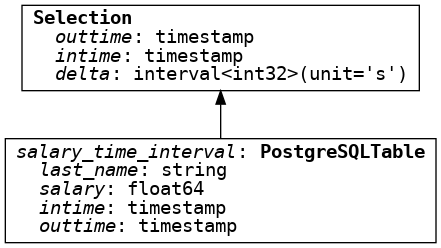

In [7]:
expr = (t.outtime - t.intime).name("delta")

t2 = t.projection(['outtime',  'intime']).mutate(expr)
t2

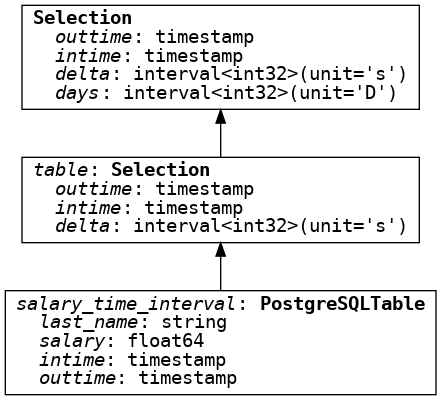

In [8]:
t3 = t2.mutate(days=t2.delta.days)
t3